## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
import folium
import matplotlib.ticker as ticker
import scipy.stats
import webbrowser
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from IPython.display import display, HTML, Image
import json
from scipy import stats
%matplotlib inline
import dataframe_image as dfi
import mgwr
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import pysal
from pysal.model import spreg
import textwrap
import matplotlib.colors as colors

## Prepare the Datasets

In [2]:
# read in the Re-ordered Oxfordshire PPFI (V2) data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/PPFI - Index Data/PPFI V2 Ox Reordered.xlsx"
ppfi_Ox_Reordered = pd.read_excel(file_path)

# read in the MSOA-level MI Emergency Admissions Data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Storyline Data/Health Outcomes in Oxfordshire - Overview/OHID Local Health Data/Cleaned - OHID - Oxfordshire Local Health Data.xlsx"
MI_Ox = pd.read_excel(file_path)

# read in the LSOA-MSOA 2011 Lookup table
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Geographies Data/Lookup and Matching Geographies/2011 OA LSOA MSOA.csv"
LSOA11_MSOA11 = pd.read_csv(file_path)

# read in the JSON data to get the coordinates
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Geographies Data/Oxfordshire Geographies Data/Oxfordshire LSOAs.json"
Ox_JSON = gpd.read_file(file_path)

# read in the Oxon Demographics Data (Household count, Population Density, RUC)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Storyline Data/Demographics Data - Oxfordshire/Oxon Demographics (RUC, Household, Pop Density).xlsx"
Ox_dem = pd.read_excel(file_path)

### Remove unwanted columns from the geographic lookup table

In [3]:
LSOA11_MSOA11 = LSOA11_MSOA11[['LSOA11CD','LSOA11NM','MSOA11CD','MSOA11NM']]

In [4]:
LSOA11_MSOA11 = LSOA11_MSOA11.drop_duplicates()

### Rename the JSON columns appropriately

In [5]:
Ox_JSON = Ox_JSON.rename(
columns = {
    'geo_code':'LSOA11CD',
    'geo_label':'LSOA11NM'
}
)

### Filter the Lookup table for Oxfordshire LSOAs by merging it with the JSON file

In [6]:
LSOA11_MSOA11 = LSOA11_MSOA11.merge(Ox_JSON[['LSOA11CD','geometry']], on='LSOA11CD',how='inner')

### Merge the dataset with the PPFI data

In [7]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(LSOA11_MSOA11[['LSOA11CD','MSOA11CD','geometry']], on='LSOA11CD',how='inner')

### Merge the dataset with the MI Admissions data

In [8]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(MI_Ox[['MSOA11CD','MI Admissions']], on='MSOA11CD',how='inner')

### Convert the merged dataframe to a GeoPandas one

In [9]:
ppfi_Ox_Reordered = gpd.GeoDataFrame(ppfi_Ox_Reordered, geometry = 'geometry')

### Convert the geometry column to centroids in order to fit the GWR model

In [10]:
points = ppfi_Ox_Reordered.centroid

C:\Users\medaamm\AppData\Local\Temp\ipykernel_10836\4215279618.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = ppfi_Ox_Reordered.centroid


## Fit a model for Child Obesity at the Reception Year as DV and PPFI dimensions as IVs

### Correct the data types of all columns to numeric

In [11]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
ppfi_Ox_Reordered[cols] = ppfi_Ox_Reordered[cols].apply(pd.to_numeric)

### Define the dependent and independent variables

In [12]:
# define the dependent variable as MI Emergency Admissions rates
y = ppfi_Ox_Reordered['MI Admissions'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[cols].values

### Define the point coordinates of the LSOA centroids

In [13]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model to select the optimal bandwidth

In [14]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

80.0


### Fit the model

In [15]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the model results

In [16]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [17]:
global_R2 = gwr_results.R2
print(global_R2)

0.6905859460887211


### Plot the local R2 at the LSOA level (Static Map)

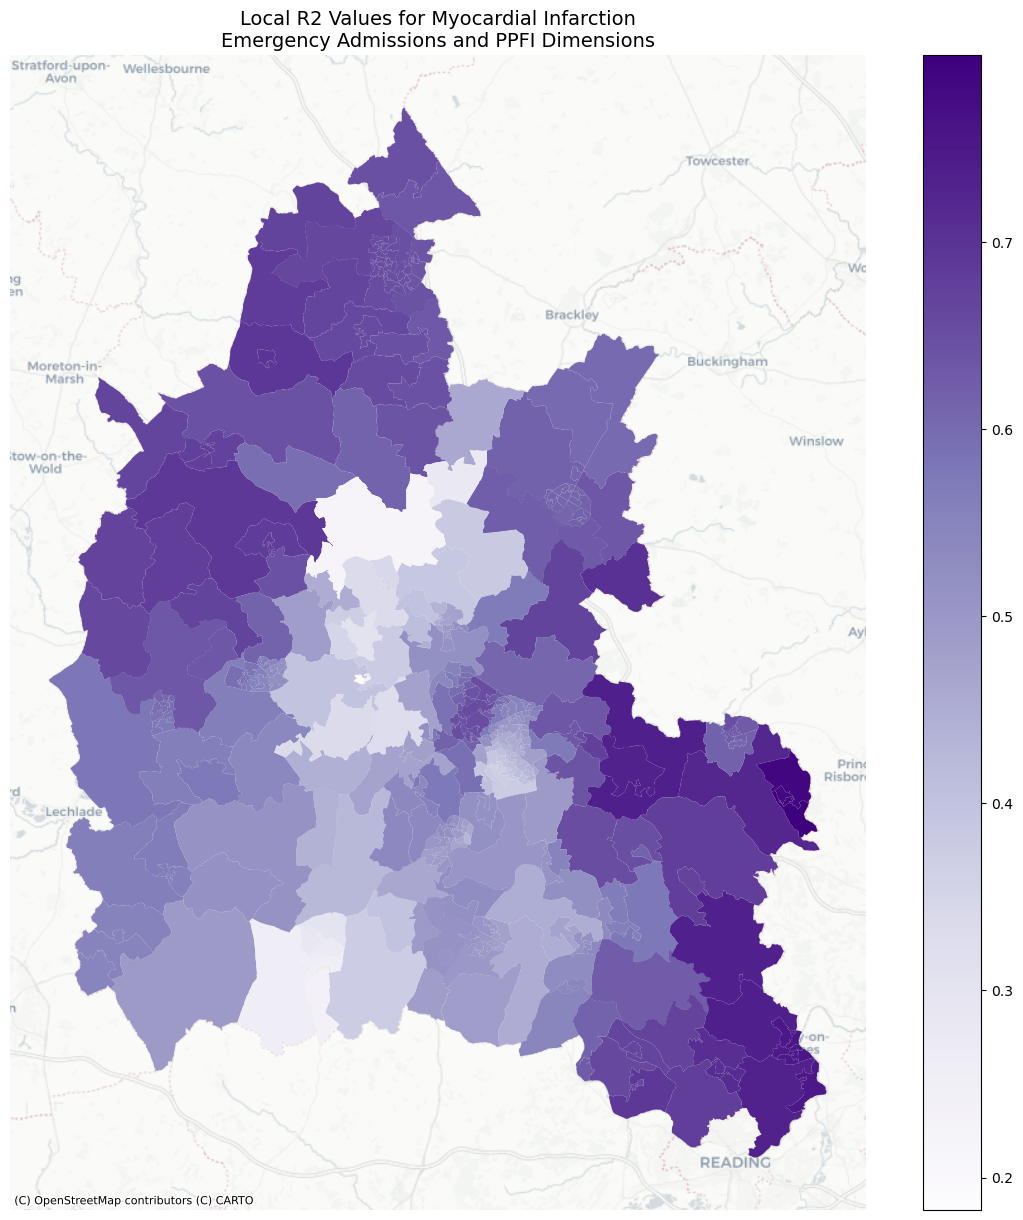

In [18]:
# plot the R2 values
ppfi_Ox_Reordered['R2'] = gwr_results.localR2

# define custom color map for R2
vmin = ppfi_Ox_Reordered['R2'].min()
vmax = ppfi_Ox_Reordered['R2'].max()
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)

fig,ax = plt.subplots(figsize=(15,15))
ppfi_Ox_Reordered.to_crs('EPSG:3857').plot(ax=ax, column='R2', legend=True, cmap='Purples', norm=norm)
plt.axis('off')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
title = 'Local R2 Values for Myocardial Infarction Emergency Admissions and PPFI Dimensions'
wrapped_title = '\n'.join(textwrap.wrap(title,45))
plt.title(wrapped_title, fontsize=14)
plt.show()

### Explore the coefficient estimates by creating a dataframe containing all the values

In [19]:
# Create a table for the Model coefficients and intercept values
model_parameters_MI = pd.DataFrame(gwr_results.params, 
                               columns = ['Intercept','Supermarket Proximity', 
                                          'Supermarket Accessibility','Non-Supermarket Proximity',
                                          'Fuel Poverty','Socio-demographic Barriers',
                                          'Food Support for Families',
                                          'E-Commerce Access']
                               )

# add the geometry and LSOA columns to the model parameters dataframe
model_parameters_MI = model_parameters_MI.assign(LSOA11CD = ppfi_Ox_Reordered['LSOA11CD'])
model_parameters_MId = model_parameters_MI.assign(LSOA11NM = ppfi_Ox_Reordered['LSOA11NM'])
model_parameters_MI = model_parameters_MI.assign(geometry = ppfi_Ox_Reordered['geometry'])
model_parameters_MI = model_parameters_MI.assign(localR2 = ppfi_Ox_Reordered['R2'])
model_parameters_MI = model_parameters_MI.assign(District = ppfi_Ox_Reordered['District'])

### Create a summary of the model parameters for each of the five districts

In [20]:
Districts_modelParams = model_parameters_MI[['Intercept', 'Supermarket Proximity', 'Supermarket Accessibility',
       'Non-Supermarket Proximity', 'Fuel Poverty',
       'Socio-demographic Barriers', 'Food Support for Families',
       'E-Commerce Access','District']].groupby('District').agg(['mean','median'])

Districts_modelParams.to_excel("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                              sheet_name = "Model 2 District-Level Summary")

### Convert the created dataframe to a GeoPandas one for creating maps

In [21]:
model_parameters_MI = gpd.GeoDataFrame(model_parameters_MI, geometry='geometry')

### Generate maps for estimated coefficients

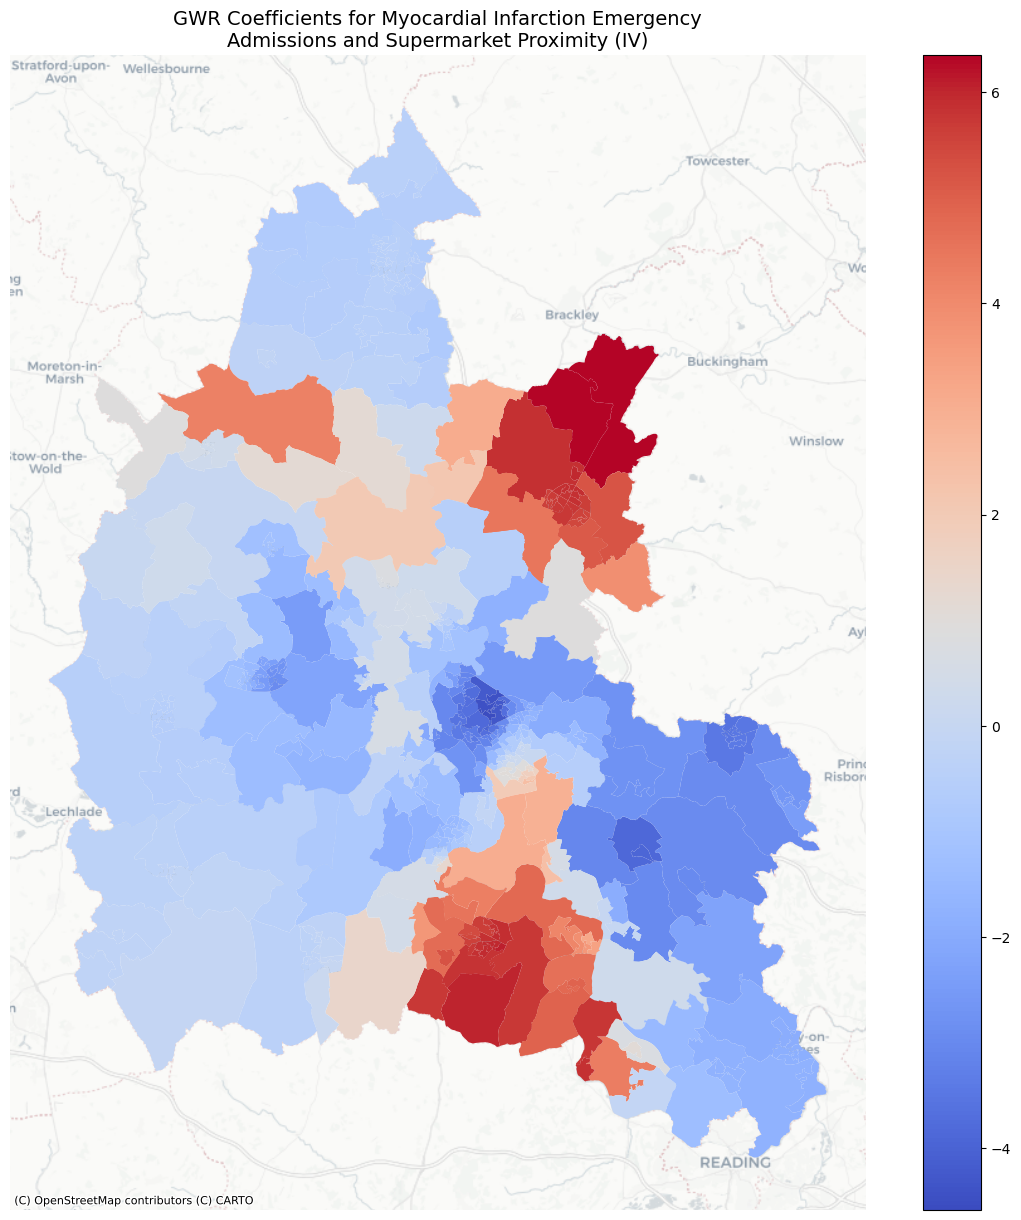

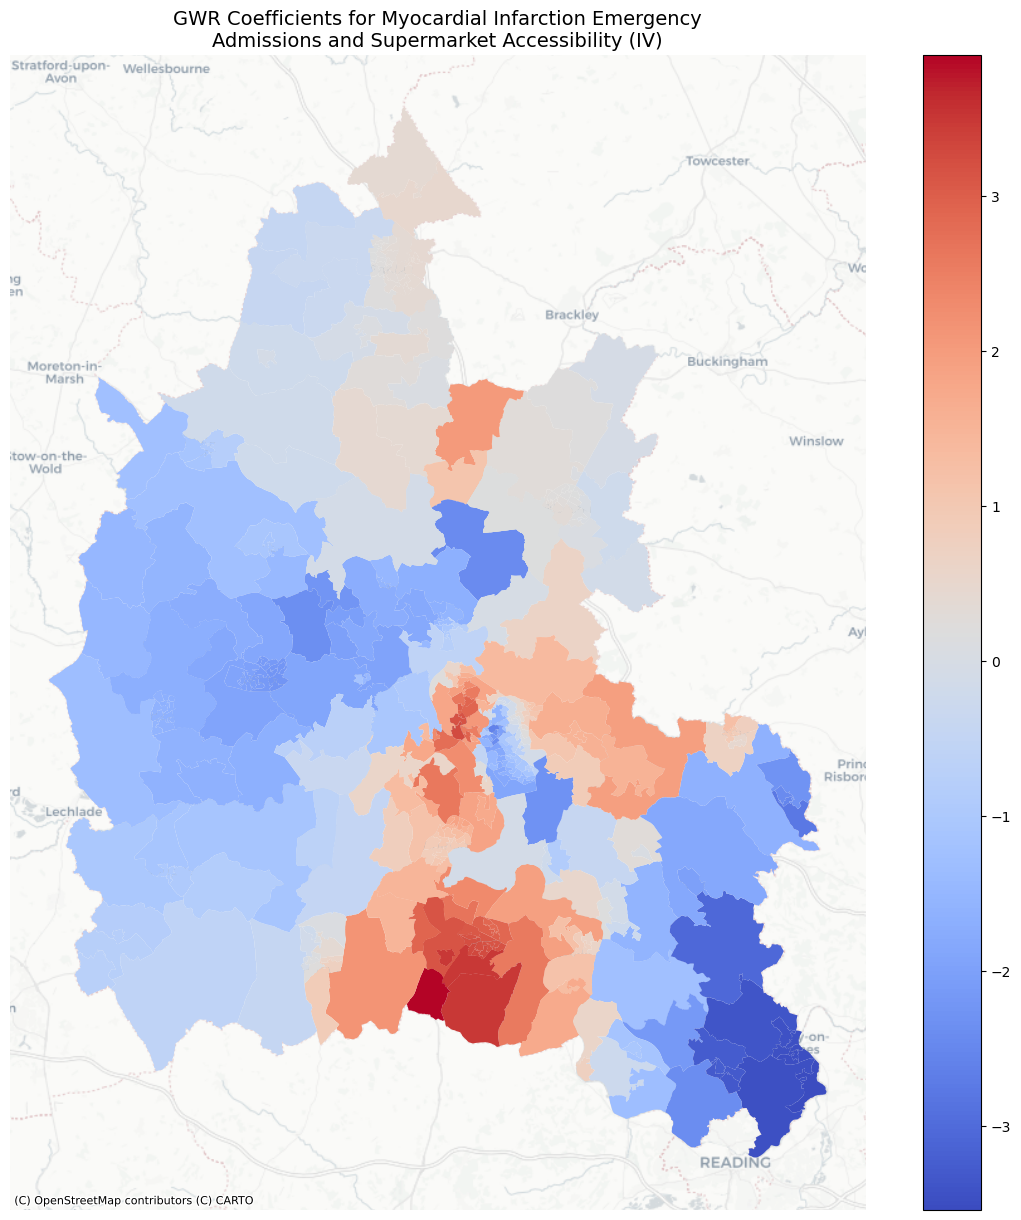

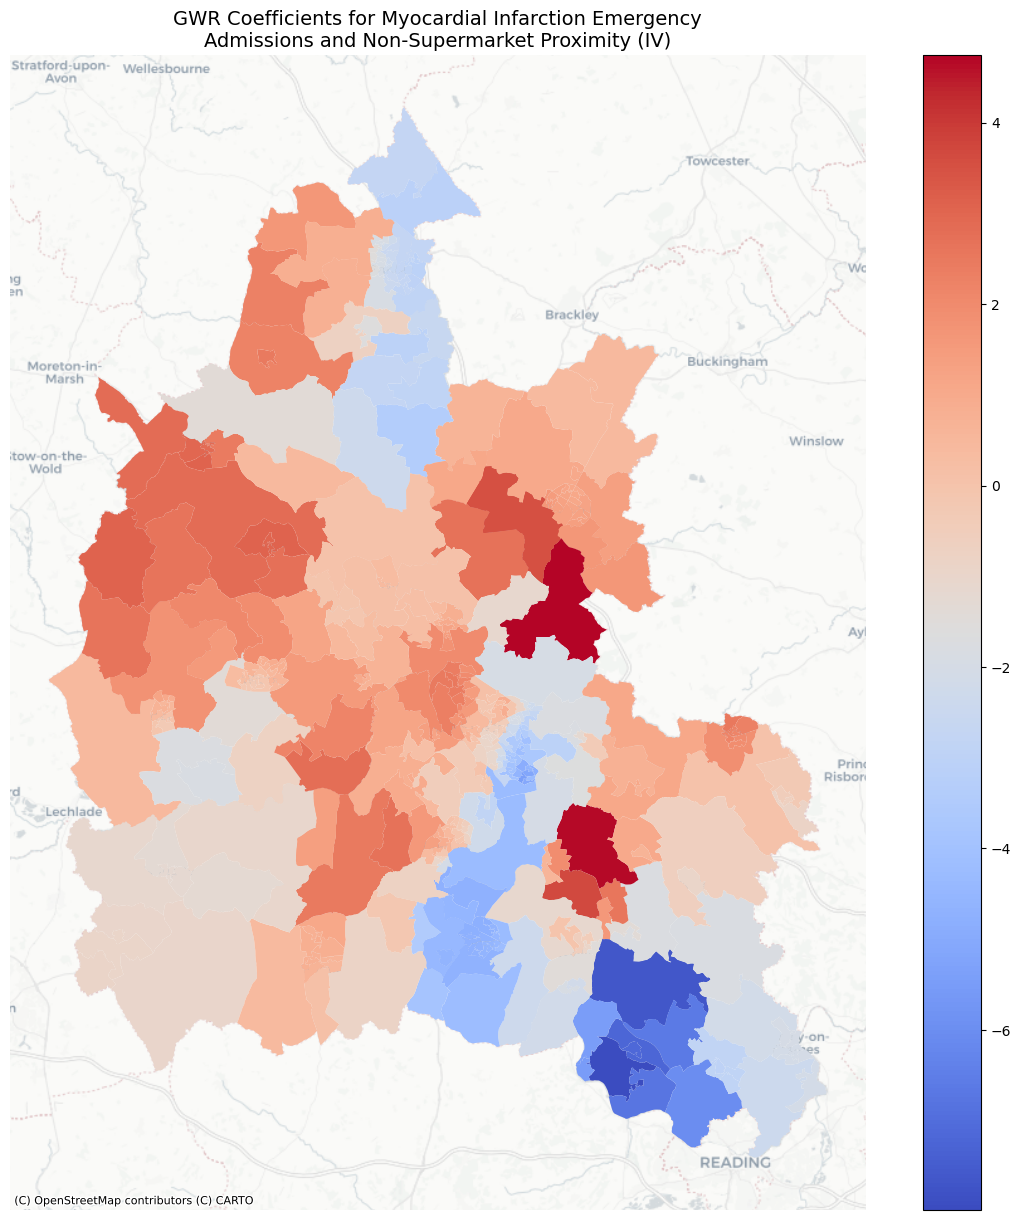

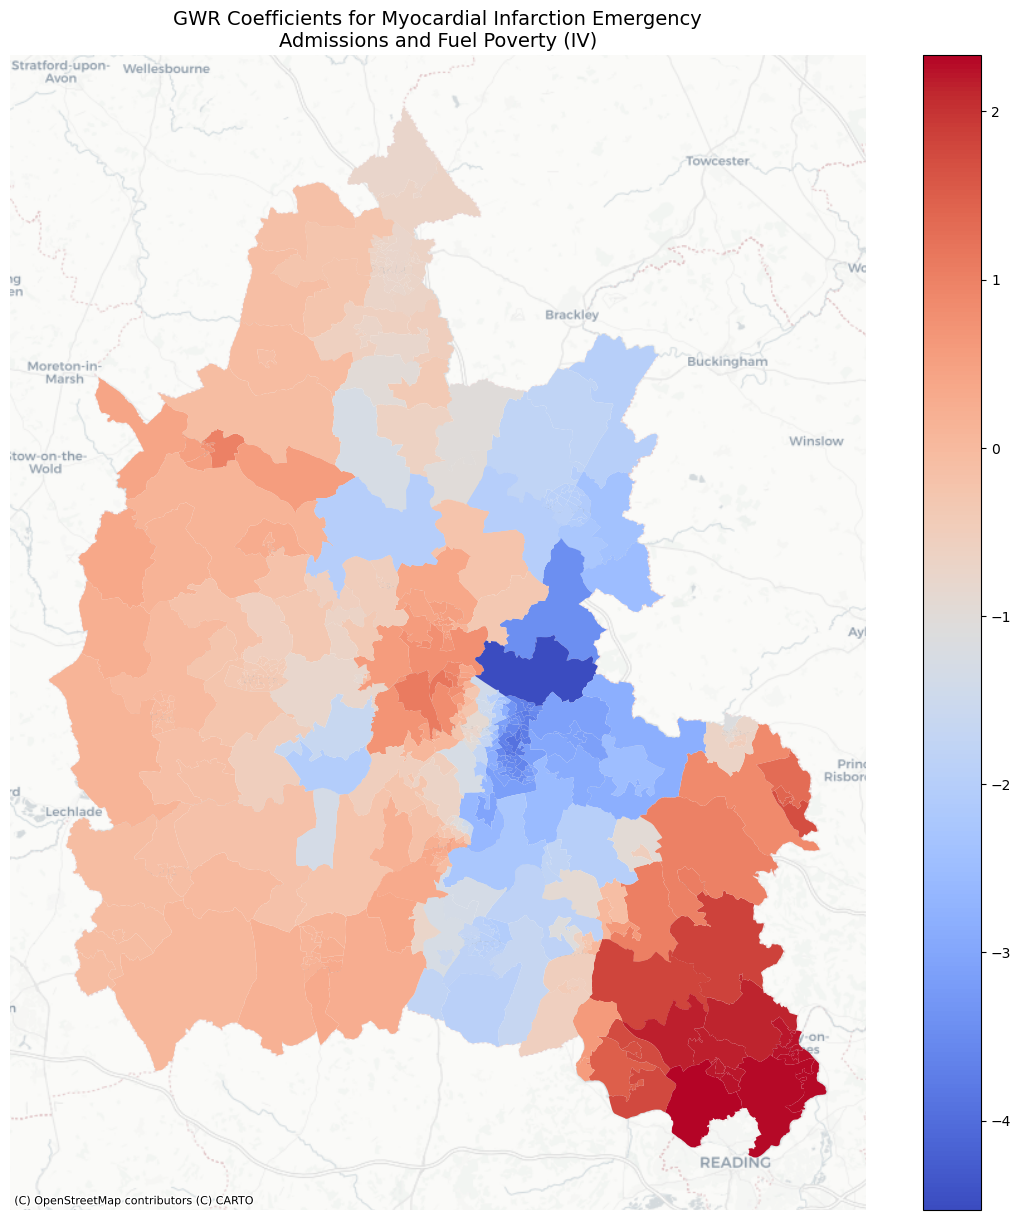

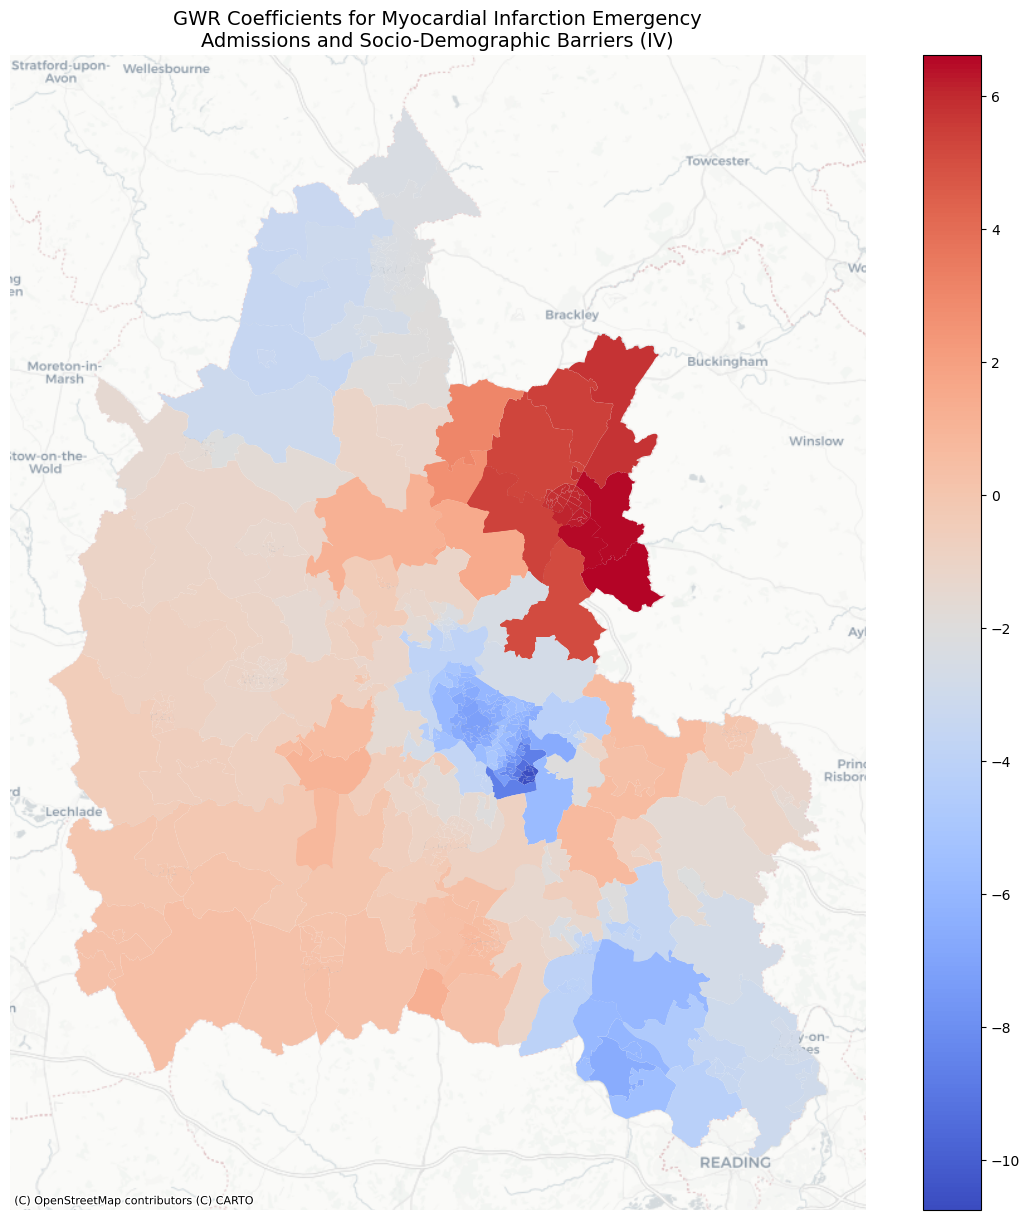

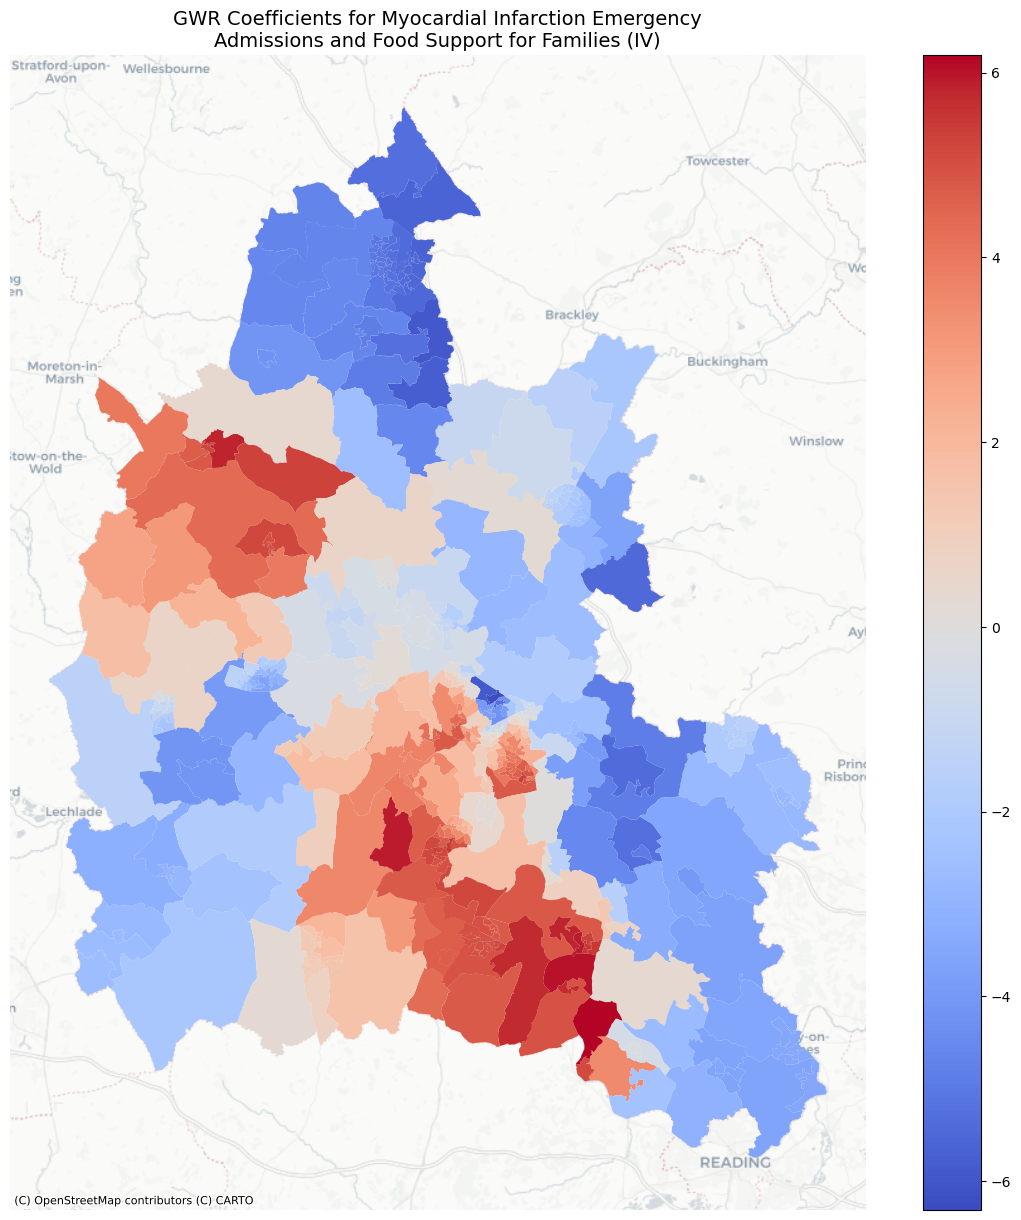

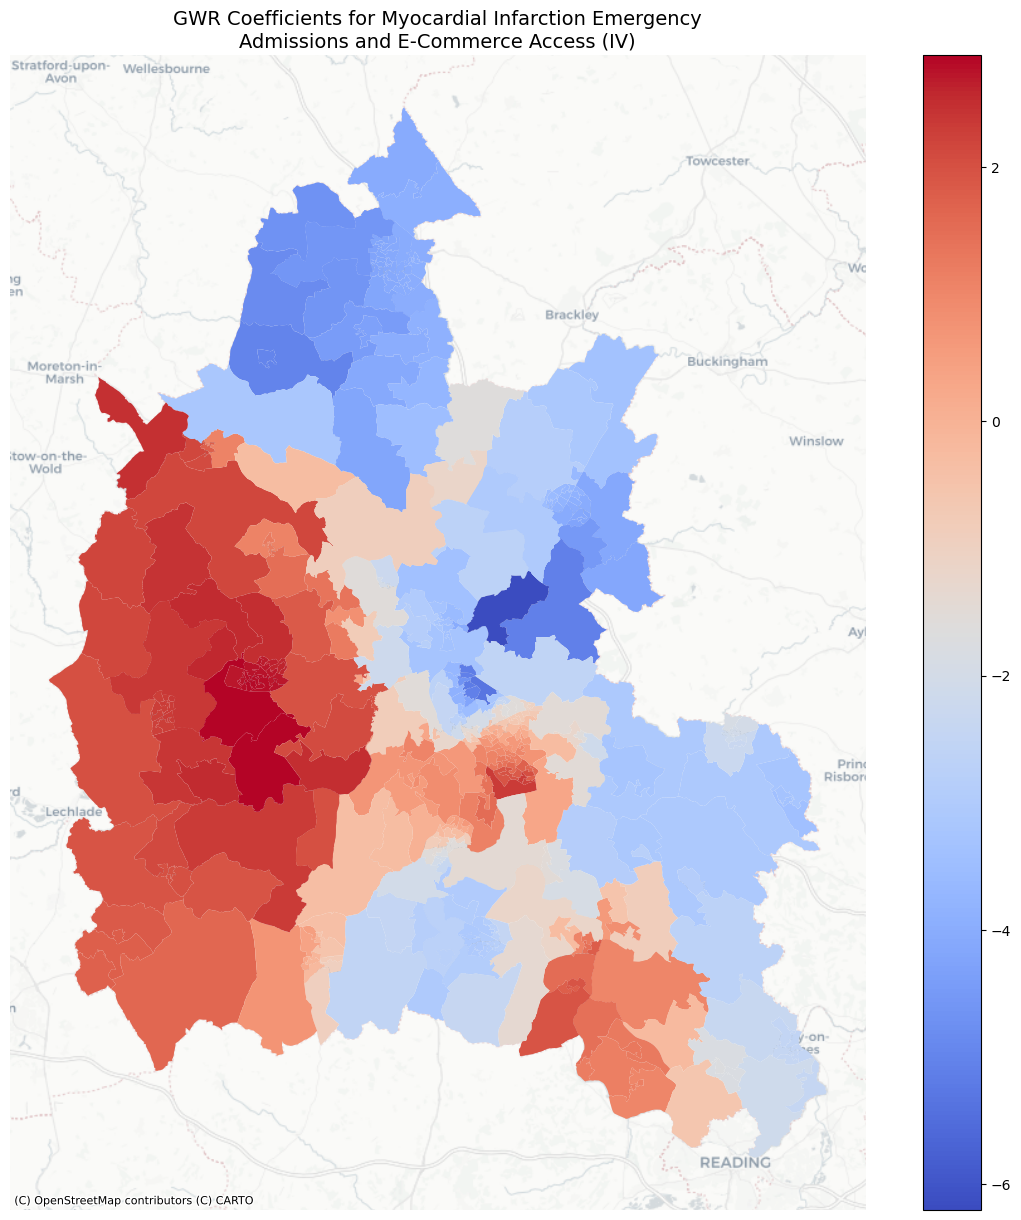

In [22]:
cols = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
       'E-Commerce Access']
titles = ['Supermarket Proximity', 'Supermarket Accessibility', 'Non-Supermarket Proximity', 'Fuel Poverty',
         'Socio-Demographic Barriers','Food Support for Families', 'E-Commerce Access']

for i,col,title in zip(range(len(cols)),cols,titles):
    fig,ax = plt.subplots(figsize=(15,15))
    
    # define custom color map for the coefficients
    vmin = model_parameters_MI[col].min()
    vmax = model_parameters_MI[col].max()
    norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)
    
    model_parameters_MI.to_crs('EPSG:3857').plot(ax=ax, column=col, legend=True, cmap='coolwarm',
                                                        norm=norm)
    title = f"GWR Coefficients for Myocardial Infarction Emergency Admissions and {title} (IV)"
    wrapped_title = '\n'.join(textwrap.wrap(title,55))
    plt.title(wrapped_title, fontsize=14)
    ax.set_axis_off()
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
    plt.show()

### Define a color map for the significant coefficient estimates

In [23]:
# define the color map, with white at zero
vmin = -11
vmax = 7
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap="RdBu"

## Explore Model Diagnostics

### Check the summary of the model results

In [24]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 429
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         193397.833
Log-likelihood:                                                   -1919.544
AIC:                                                               3855.089
AICc:                                                              3857.518
BIC:                                                             190845.959
R2:                                                                   0.298
Adj. R2:                                                              0.287

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Generate a statistical summary of the model results

In [25]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(8):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the Parameters Summary to an Excel file

In [26]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 2 Parameters Summary")


### Define a formatting style for the plots to come

In [27]:
kwargs = {'edgecolor':'black',
         'linewidth':0.5
         }

### Visualizing the statistical significance of the parameter estimates

In [28]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# column names used to loop through and capture the model estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# loop through to capture the parameter estimates
for col,i in list(zip(columns_significance, range(1,8))):
    parameter_estimates[col] = gwr_results.params[:,i]
    parameter_estimates[col+"_t"] = filter_t[:,i]
    parameter_estimates[col+"_tc"] = filter_tc[:,i]

# add other useful columns 
parameter_estimates[['LSOA11CD','LSOA11NM','geometry','District']] = ppfi_Ox_Reordered[['LSOA11CD','LSOA11NM','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

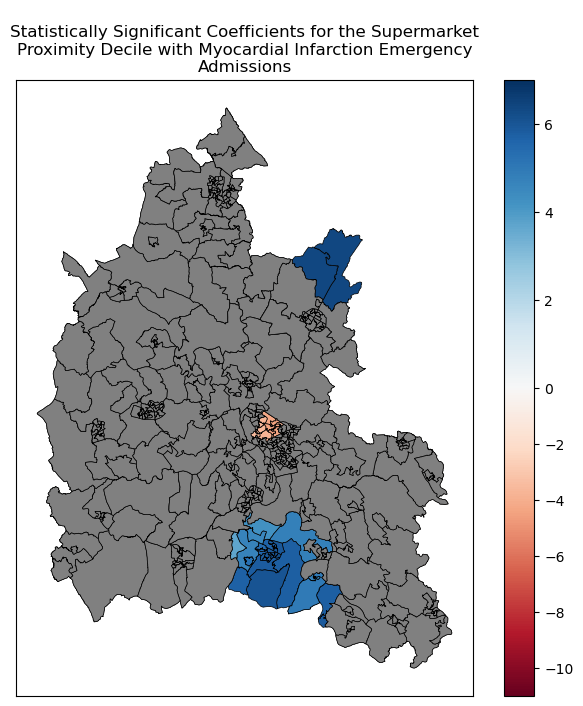

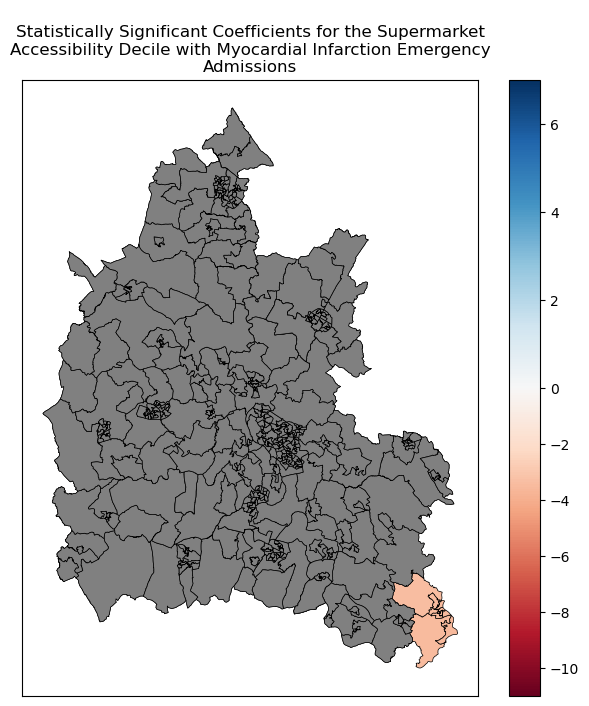

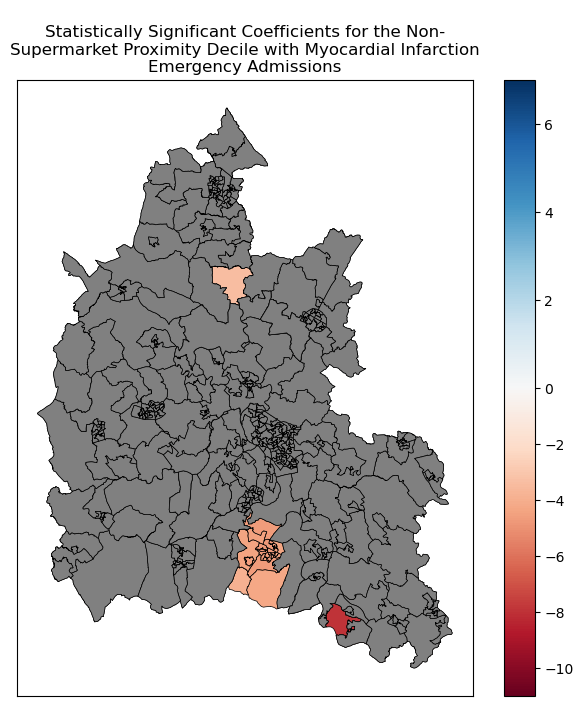

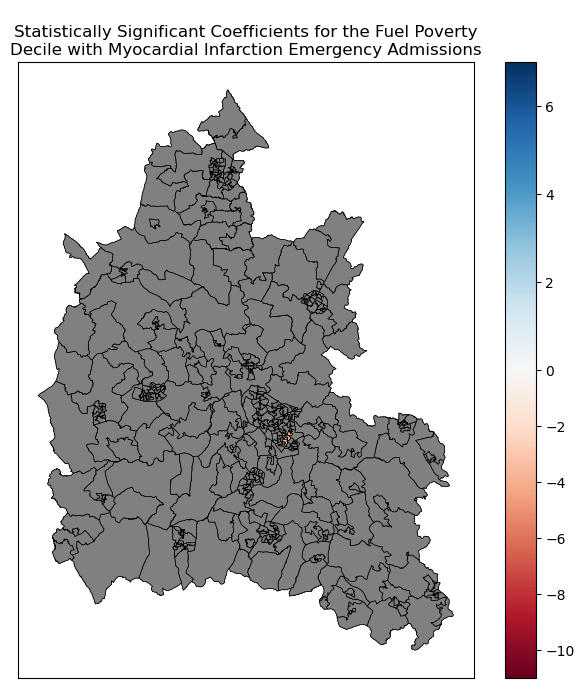

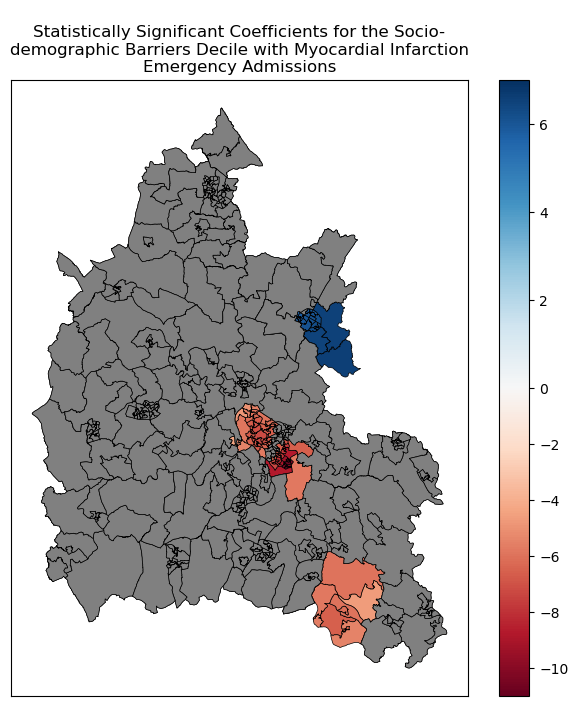

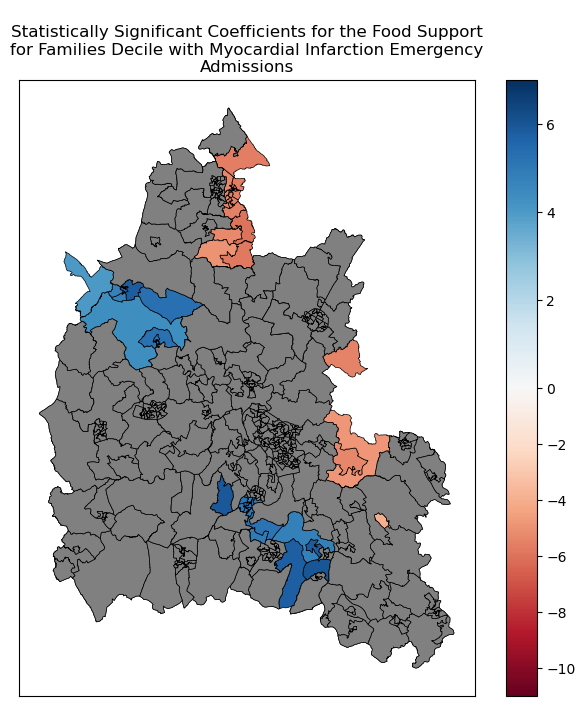

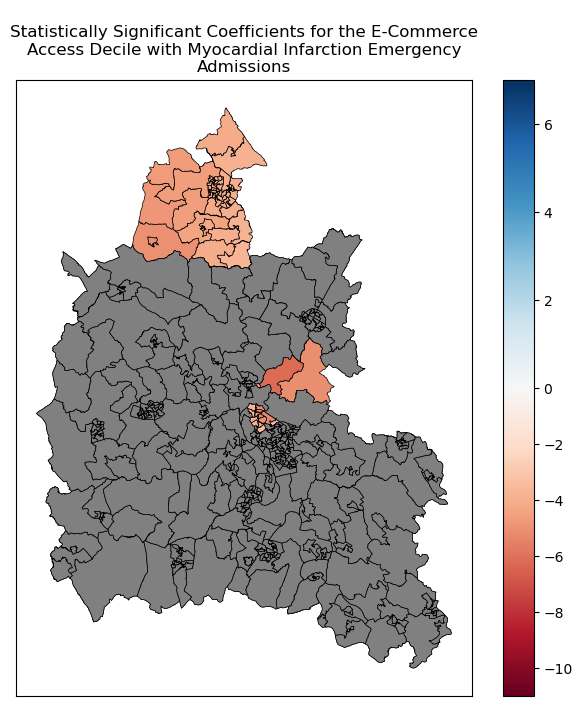

In [29]:
# define a list of column names used to generate the maps
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list of dimension names to used to set titles for the maps
title_dimensions = ['Supermarket Proximity',
                   'Supermarket Accessibility',
                   'Non-Supermarket Proximity',
                   'Fuel Poverty',
                   'Socio-demographic Barriers',
                    'Food Support for Families',
                   'E-Commerce Access']

# create the maps
for col,title in list(zip(columns_significance,title_dimensions)):
    fig,ax = plt.subplots(figsize=(8,8))
    parameter_estimates.plot(
    col,
    ax=ax,
    legend=True,
    cmap=cmap,
    **kwargs,
    norm=norm
    )
    parameter_estimates[parameter_estimates[col+'_tc'] == 0].plot(ax=ax,
                                                                 color='grey',
                                                                 **kwargs)
    title = f"Statistically Significant Coefficients for the {title} Decile with Myocardial Infarction Emergency Admissions"
    ax.set_title("\n".join(textwrap.wrap(title,60)))                                                             
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [30]:
# define a list of dimensions names used to capture the parameter estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list of excel worksheet names for exporting later
sheet_names = ['SM_Prox','SM_Acc','NonSM_Prox','FuelPov','SD','FFF','E_Comm']

# define a dictionnary showing the district names and the total LSOAs (2011) count of each to add that 
# to the district summaries
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}

# list of statistical measures
lst = ['Mean','Median','LSOA_Count','Minimum','Maximum']

# create the statistical summary
for col,sheet_name in zip(columns_significance, sheet_names):
    district_estimates = parameter_estimates[parameter_estimates[col+"_tc"] !=0].groupby('District').agg(
        LSOA_Count=('LSOA11CD','count'),
        Mean=(col,'mean'),
        Median = (col,'median'),
        Minimum = (col,'min'),
        Maximum = (col,'max')
    ).reset_index()
    district_estimates['Total_LSOAs'] = district_estimates['District'].map(LSOAs_Count)
    district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,2)
    district_estimates[lst] = district_estimates[lst].round(3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                   engine="openpyxl", mode="a") as writer:
        district_estimates.to_excel(writer, sheet_name = f"Summary_{sheet_name}")

### Get the significant LSOAs list for each District and Dimension

In [31]:
for col,sheet_name in zip(columns_significance,sheet_names):
    Sig_LSOA_list = parameter_estimates[parameter_estimates[col+"_tc"] != 0].round(3)
    Sig_LSOA_list = Sig_LSOA_list[['LSOA11CD','District',col]].merge(Ox_dem[['LSOA11CD','LSOA21CD','LSOA21NM','RUC11']], 
                                                                             on='LSOA11CD',how='inner').reset_index()
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                   engine="openpyxl", mode="a") as writer:
        Sig_LSOA_list.to_excel(writer, sheet_name = f"Sig_{sheet_name}")

### Group the distict-level estimates of LSOAs by the RUC classification

In [32]:
# create a dictionnary of the Cherwell LSOAs count by RUC classification 
District_RUC_LSOA_Count = {
    "Cherwell":{
        "Urban city and town": 69,
        "Rural village and dispersed": 26,
        "Rural town and fringe": 7
    },
    "South Oxfordshire":{
        "Urban city and town": 49,
        "Rural village and dispersed": 21,
        "Rural town and fringe": 23
    },
    "West Oxfordshire":{
        "Urban city and town": 28,
        "Rural village and dispersed": 19,
        "Rural town and fringe": 21
    },
    "Oxford":{
        "Urban city and town": 84,
        "Rural village and dispersed": 0,
        "Rural town and fringe": 1
    },
    "Vale of White Horse":{
        "Urban city and town": 49,
        "Rural village and dispersed": 10,
        "Rural town and fringe": 22
    }
}

# define a list of excel worksheet names for exporting later
sheet_names = ['SM_Prox','SM_Acc','NonSM_Prox','FuelPov','SD','FFF','E_Comm']

# define a function to get the LSOA count values from the dictionnary defined above
def get_value(row):
    return District_RUC_LSOA_Count[row["District"]][row['RUC11']]

# create the dataframe
for col,sheet_name in zip(columns_significance,sheet_names):
    Grouped_RUC = parameter_estimates[parameter_estimates[col+"_tc"] != 0]
    Grouped_RUC = Grouped_RUC[['LSOA11CD','District',col]].merge(Ox_dem[['LSOA11CD','RUC11']], on='LSOA11CD', how='inner')
    Grouped_RUC = Grouped_RUC.groupby(['District','RUC11']).agg(
        LSOA_Count = ('LSOA11CD','count'),
        Coeff_Average = (col,'mean')
    ).reset_index()
    Grouped_RUC['Total_LSOAs'] = Grouped_RUC.apply(get_value, axis=1)
    Grouped_RUC['Coeff_Average'] = round(Grouped_RUC['Coeff_Average'],3)
    Grouped_RUC['LSOA_Coverage'] = round(Grouped_RUC['LSOA_Count']/Grouped_RUC['Total_LSOAs']*100,2)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                   engine="openpyxl", mode="a") as writer:
        Grouped_RUC.to_excel(writer, sheet_name = f"Sig_RUC_{sheet_name}")

## Fit a GWR model with the Prevalence of Child Obesity at the RY as the dependent variable and the PPFI combined decile as the independent variable

### Define the variables

In [33]:
# define the dependent variable as RY obesity levels
y = ppfi_Ox_Reordered['MI Admissions'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[['PPFI Combined Decile']].values

y = np.array(y)
X = np.array(X)

### Define the coordinates

In [34]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model and compute the optimal bandwidth

In [35]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

45.0


### Fit the model

In [36]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the results

In [37]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [38]:
global_R2 = gwr_results.R2
print(global_R2)

0.5744781759428739


## Model Diagnostics

### View the statistical summary of the model results

In [39]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 429
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         238568.149
Log-likelihood:                                                   -1964.569
AIC:                                                               3933.138
AICc:                                                              3935.195
BIC:                                                             235979.907
R2:                                                                   0.135
Adj. R2:                                                              0.133

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Create a statistical summary of the model parameters

In [40]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Combined Decile']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(2):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the statistical Summary to an Excel file

In [41]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 1 Parameters Summary")

### Visualize the Statistical Significance of the Parameter Estimates

In [42]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# capture the parameter estimates
parameter_estimates['PPFI Combined Decile'] = gwr_results.params[:,1]
parameter_estimates['PPFI Combined Decile_t'] = filter_t[:,1]
parameter_estimates['PPFI Combined Decile_tc'] = filter_tc[:,1]

# add other useful columns 
parameter_estimates[['LSOA11CD','LSOA11NM','geometry','District']] = ppfi_Ox_Reordered[['LSOA11CD','LSOA11NM','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

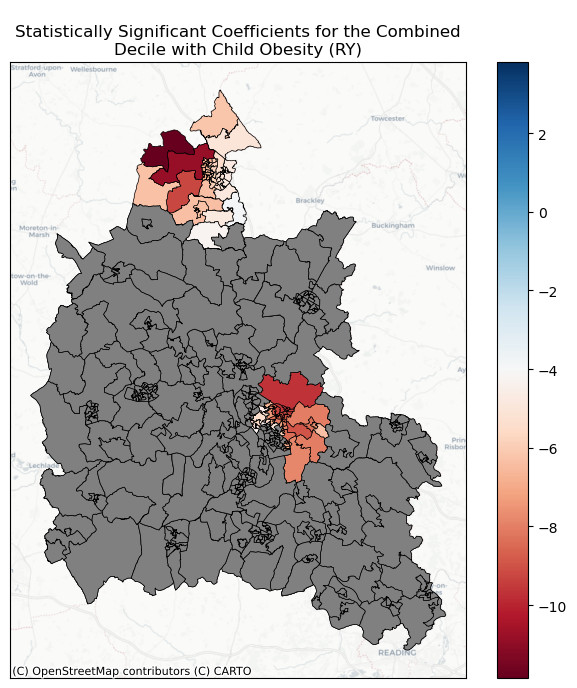

In [43]:
# generate the map of the statistically significant parameter estimates
fig,ax = plt.subplots(figsize=(8,8))

parameter_estimates.plot(
    'PPFI Combined Decile',
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap
)

parameter_estimates[filter_tc[:,1] == 0].plot(ax=ax,
                                              color='grey',
                                            **kwargs
                                             )
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = f"Statistically Significant Coefficients for the Combined Decile with Child Obesity (RY)"
ax.set_title("\n".join(textwrap.wrap(title,60)))  
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

plt.show()

In [44]:
district_estimates = parameter_estimates[filter_tc[:,1] !=0].groupby('District').agg(LSOA_Count = ('LSOA11CD','count'),
                                            Mean = ('PPFI Combined Decile','mean'),
                                            Median = ('PPFI Combined Decile','median'),
                                            Minimum = ('PPFI Combined Decile','min'),
                                            Maximum = ('PPFI Combined Decile','max')
                                                               )
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Myocardial Infarction Emergency Admissions/Oxfordshire/GWR with MI.xlsx",
                   engine="openpyxl", mode="a") as writer:
    district_estimates.to_excel(writer, sheet_name = "Model 1_Sig")

### Notes

In [45]:
ppfi_Ox_Reordered[['District','MI Admissions']].groupby('District').mean().reset_index()

District  MI Admissions
0             Cherwell      96.410784
1               Oxford      91.070588
2    South Oxfordshire      71.819355
3  Vale of White Horse      74.040741
4     West Oxfordshire      82.005882